In [ ]:
from copy import deepcopy

import numpy as np
import torch as tr
from tqdm.auto import tqdm
import glob
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [4]:
from fair_graphs.models.graph_models import FairAutoEncoder
from fair_graphs.datasets.scalers import MinMaxScaler
from fair_graphs.datasets.graph_datasets import GermanData, BailData, CreditData, PokecData

In [ ]:
trn_device = tr.device("cuda" if tr.cuda.is_available() else "cpu")
lambdas = [1, 1e-1, 1e-2, 1e-3]

In [14]:
def optim_fairAutoEncoder(num_splits, 
                          num_samples, 
                          num_feat,
                          data, 
                          lambdas, 
                          learning_rate = 1e-3, 
                          num_epochs = 500, 
                          verbose = False, 
                          metric = 'dp',
                          pos = 0,
                          db = 'German',
                          train_percentage = .7,
                        ):
  scaler = MinMaxScaler(feature_range = (0, 1))
  mses = np.zeros((len(lambdas)))
  fair_losses = np.zeros((len(lambdas)))

  num_samples = len(data)
  indices = np.arange(num_samples)
  y = tr.stack((data.labels, data.sensitive)).T.cpu() #if include_sensitive else dataset.labels.cpu()

  for split_idx in tqdm(range(num_splits)):
    trn_idxs, _ = train_test_split(indices, train_size=train_percentage, stratify=y, random_state=split_idx)
    trn_data = deepcopy(data)
    trn_data.sample_data_from_indices(trn_idxs)
    trn_data.samples = scaler.fit_transform(trn_data.samples)
    trn_data = trn_data.to(trn_device)

    for idxl, lam in enumerate(lambdas):
        fae = FairAutoEncoder(num_feat, num_feat)
        mse, fair_loss = fae.fit(trn_data,
                                  learning_rate = learning_rate,
                                  num_epochs = num_epochs,
                                  verbose = verbose,
                                  lambda_ = lam,
                                  metric = metric,
                                  pos = pos,
                                  db = db,
                                  split_idx = split_idx)
        mses[idxl] += mse
        fair_losses[idxl] += fair_loss

  mses /= num_splits
  fair_losses /= num_splits

  return mses, fair_losses

## German

In [5]:
data = GermanData(sensitive_attribute = 'Gender',
                  target_attribute = 'GoodCustomer',
                  include_sensitive = True,
                  num_samples = 0,
                  pre_scale_features = False)

data.samples.shape, data.sensitive.shape, data.labels.shape, data.adj_mtx

(torch.Size([1000, 27]),
 torch.Size([1000]),
 torch.Size([1000]),
 <1000x1000 sparse matrix of type '<class 'numpy.float64'>'
 	with 3662 stored elements in Compressed Sparse Row format>)

In [4]:
num_splits = 50
num_samples, num_feat = data.samples.shape
db = 'German'

In [ ]:
mses_dp, fair_losses_dp = optim_fairAutoEncoder(num_splits,
                                                num_samples,
                                                num_feat,
                                                data,
                                                lambdas,
                                                metric = 'dp')

In [ ]:
mses_eo0, fair_losses_eo0 = optim_fairAutoEncoder(num_splits,
                                                  num_samples,
                                                  num_feat,
                                                  data,
                                                  lambdas,
                                                  metric = 'eo',
                                                  pos = 0)

100%|██████████| 50/50 [13:54<00:00, 16.69s/it]


In [ ]:
mses_eo1, fair_losses_eo1 = optim_fairAutoEncoder(num_splits,
                                                  num_samples,
                                                  num_feat,
                                                  data,
                                                  lambdas,
                                                  metric = 'eo',
                                                  pos = 1)

100%|██████████| 50/50 [12:15<00:00, 14.71s/it]


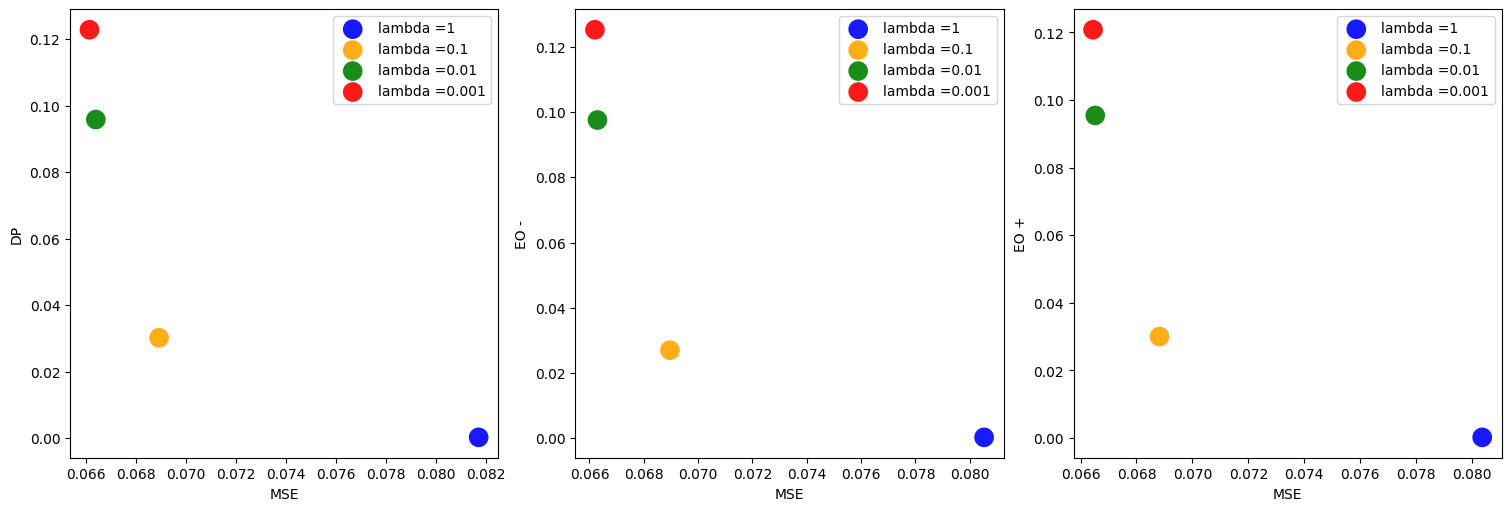

In [ ]:
#old
fig, axs = plt.subplots(1, 3, figsize=(15, 5), constrained_layout = True)

for ic, color in enumerate(['blue', 'orange', 'green', 'red']):
    axs[0].scatter(mses_dp[ic], fair_losses_dp[ic], c=color, s=200, label='lambda =' + str(lambdas[ic]),
               alpha=0.9, edgecolors='none')
    axs[1].scatter(mses_eo0[ic], fair_losses_eo0[ic], c=color, s=200, label='lambda =' + str(lambdas[ic]),
               alpha=0.9, edgecolors='none')
    axs[2].scatter(mses_eo1[ic], fair_losses_eo1[ic], c=color, s=200, label='lambda =' + str(lambdas[ic]),
               alpha=0.9, edgecolors='none')

    
axs[0].set(xlabel='MSE', ylabel='DP')
axs[1].set(xlabel='MSE', ylabel='EO -')
axs[2].set(xlabel='MSE', ylabel='EO +')
axs[0].legend()
axs[1].legend()
axs[2].legend()
plt.show()

## Bail

In [ ]:
data = BailData(sensitive_attribute = 'WHITE',
                  target_attribute = 'RECID',
                  include_sensitive = True,
                  num_samples = 0,
                  pre_scale_features = False)

data.samples.shape, data.sensitive.shape, data.labels.shape, data.adj_mtx

(torch.Size([18876, 18]),
 torch.Size([18876]),
 torch.Size([18876]),
 tensor([[1., 0., 0.,  ..., 0., 0., 0.],
         [0., 1., 0.,  ..., 0., 0., 0.],
         [0., 0., 1.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 1., 0., 0.],
         [0., 0., 0.,  ..., 0., 1., 0.],
         [0., 0., 0.,  ..., 0., 0., 1.]], dtype=torch.float64))

In [ ]:
num_samples, num_feat = data.samples.shape
db = 'Bail'

In [ ]:
mses_dp, fair_losses_dp = optim_fairAutoEncoder(num_splits, 
                          num_samples, 
                          num_feat,
                          data, 
                          lambdas,
                          metric = 'dp',
                          db = db
                        )

100%|██████████| 50/50 [3:37:19<00:00, 260.79s/it]  


In [ ]:
mses_eo0, fair_losses_eo0 = optim_fairAutoEncoder(num_splits, 
                          num_samples, 
                          num_feat,
                          data, 
                          lambdas, 
                          metric = 'eo',
                          pos = 0,
                          db = db
                        )

100%|██████████| 50/50 [3:39:20<00:00, 263.20s/it]  


In [ ]:
mses_eo1, fair_losses_eo1 = optim_fairAutoEncoder(num_splits, 
                          num_samples, 
                          num_feat,
                          data, 
                          lambdas, 
                          metric = 'eo',
                          pos = 1,
                          db = db
                        )

100%|██████████| 50/50 [3:35:57<00:00, 259.16s/it]  


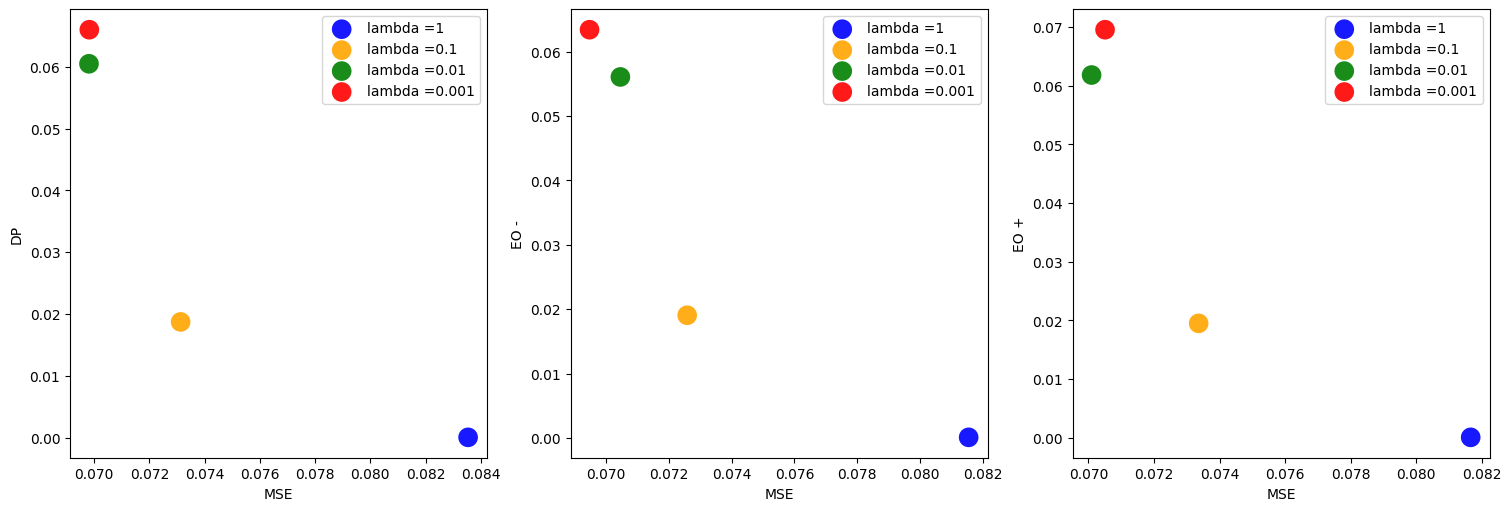

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5), constrained_layout = True)

for ic, color in enumerate(['blue', 'orange', 'green', 'red']):
    axs[0].scatter(mses_dp[ic], fair_losses_dp[ic], c=color, s=200, label='lambda =' + str(lambdas[ic]),
               alpha=0.9, edgecolors='none')
    axs[1].scatter(mses_eo0[ic], fair_losses_eo0[ic], c=color, s=200, label='lambda =' + str(lambdas[ic]),
               alpha=0.9, edgecolors='none')
    axs[2].scatter(mses_eo1[ic], fair_losses_eo1[ic], c=color, s=200, label='lambda =' + str(lambdas[ic]),
               alpha=0.9, edgecolors='none')

    
axs[0].set(xlabel='MSE', ylabel='DP')
axs[1].set(xlabel='MSE', ylabel='EO -')
axs[2].set(xlabel='MSE', ylabel='EO +')
axs[0].legend()
axs[1].legend()
axs[2].legend()
plt.show()

## Credit

In [ ]:
data = CreditData(sensitive_attribute = 'Age',
                  target_attribute = 'NoDefaultNextMonth',
                  include_sensitive = True,
                  num_samples = 0,
                  pre_scale_features = False)

data.samples.shape, data.sensitive.shape, data.labels.shape, data.adj_mtx

(torch.Size([30000, 13]),
 torch.Size([30000]),
 torch.Size([30000]),
 tensor([[1., 0., 0.,  ..., 0., 0., 0.],
         [0., 1., 0.,  ..., 0., 0., 0.],
         [0., 0., 1.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 1., 0., 0.],
         [0., 0., 0.,  ..., 0., 1., 0.],
         [0., 0., 0.,  ..., 0., 0., 1.]], dtype=torch.float64))

In [ ]:
num_samples, num_feat = data.samples.shape
db = 'Credit'

In [ ]:
mses_dp, fair_losses_dp = optim_fairAutoEncoder(num_splits, 
                          num_samples, 
                          num_feat,
                          data, 
                          lambdas,
                          metric = 'dp',
                          db = db
                        )

100%|██████████| 50/50 [1:58:47<00:00, 142.55s/it]


In [ ]:
mses_eo0, fair_losses_eo0 = optim_fairAutoEncoder(num_splits, 
                          num_samples, 
                          num_feat,
                          data, 
                          lambdas, 
                          metric = 'eo',
                          pos = 0,
                          db = db
                        )

100%|██████████| 50/50 [2:25:57<00:00, 175.16s/it]  


In [ ]:
mses_eo1, fair_losses_eo1 = optim_fairAutoEncoder(num_splits, 
                          num_samples, 
                          num_feat,
                          data, 
                          lambdas, 
                          metric = 'eo',
                          pos = 1,
                          db = db
                        )

100%|██████████| 50/50 [1:48:42<00:00, 130.45s/it]


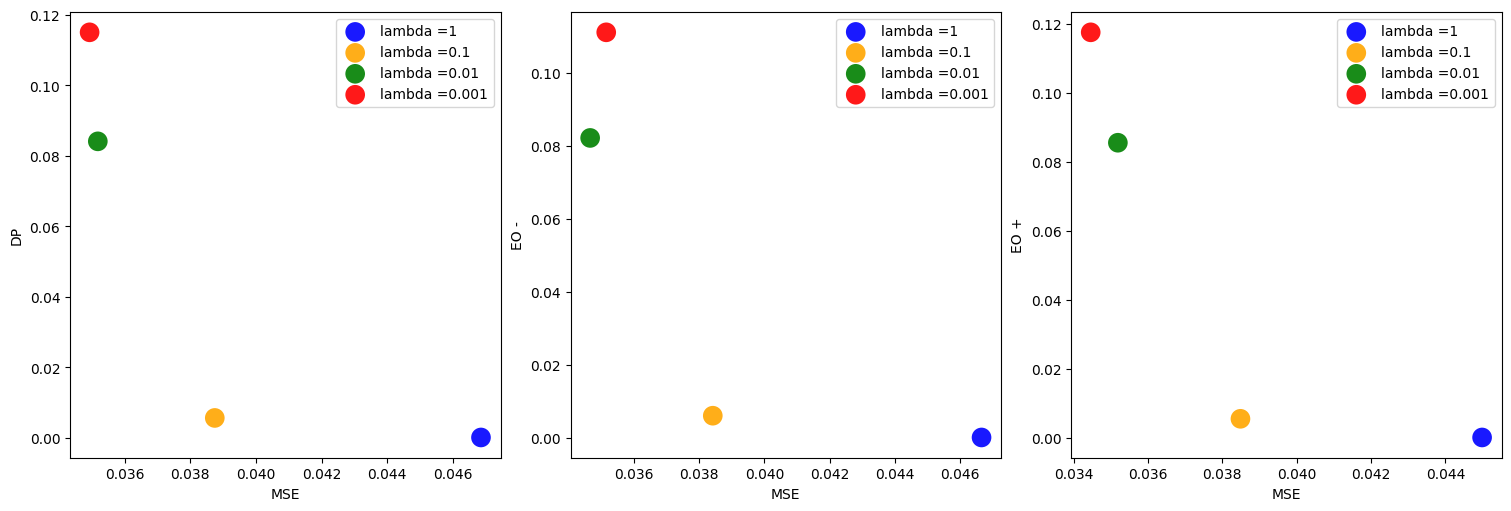

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5), constrained_layout = True)

for ic, color in enumerate(['blue', 'orange', 'green', 'red']):
    axs[0].scatter(mses_dp[ic], fair_losses_dp[ic], c=color, s=200, label='lambda =' + str(lambdas[ic]),
               alpha=0.9, edgecolors='none')
    axs[1].scatter(mses_eo0[ic], fair_losses_eo0[ic], c=color, s=200, label='lambda =' + str(lambdas[ic]),
               alpha=0.9, edgecolors='none')
    axs[2].scatter(mses_eo1[ic], fair_losses_eo1[ic], c=color, s=200, label='lambda =' + str(lambdas[ic]),
               alpha=0.9, edgecolors='none')

    
axs[0].set(xlabel='MSE', ylabel='DP')
axs[1].set(xlabel='MSE', ylabel='EO -')
axs[2].set(xlabel='MSE', ylabel='EO +')
axs[0].legend()
axs[1].legend()
axs[2].legend()
plt.show()

## Pokec 

In [6]:
data = PokecData(sensitive_attribute='region', 
                 target_attribute='marital_status_indicator',
                 include_sensitive=True, 
                 num_samples=0, 
                 pre_scale_features=False, 
                 region_suffix = 'z')

data.samples.shape, data.sensitive.shape, data.labels.shape, data.adj_mtx

(torch.Size([67796, 276]),
 torch.Size([67796]),
 torch.Size([67796]),
 <67796x67796 sparse matrix of type '<class 'numpy.float64'>'
 	with 1303712 stored elements in Compressed Sparse Row format>)

In [11]:
num_splits = 50
num_samples, num_feat = data.samples.shape

train_percentage = .4
trn_device = tr.device("cuda" if tr.cuda.is_available() else "cpu")

lambdas = [1, 1e-1, 1e-2, 1e-3]
db = 'Pokec'

In [ ]:
mses_dp, fair_losses_dp = optim_fairAutoEncoder(num_splits, 
                          num_samples, 
                          num_feat,
                          data, 
                          lambdas,
                          metric = 'dp',
                          db = db
                        )


  0%|                                                                                                                           | 0/50 [00:00<?, ?it/s]

In [ ]:
mses_eo0, fair_losses_eo0 = optim_fairAutoEncoder(num_splits, 
                          num_samples, 
                          num_feat,
                          data, 
                          lambdas, 
                          metric = 'eo',
                          pos = 0,
                          db = db
                        )

In [ ]:
mses_eo1, fair_losses_eo1 = optim_fairAutoEncoder(num_splits, 
                          num_samples, 
                          num_feat,
                          data, 
                          lambdas, 
                          metric = 'eo',
                          pos = 1,
                          db = db
                        )

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5), constrained_layout = True)

for ic, color in enumerate(['blue', 'orange', 'green', 'red']):
    axs[0].scatter(mses_dp[ic], fair_losses_dp[ic], c=color, s=200, label='lambda =' + str(lambdas[ic]),
               alpha=0.9, edgecolors='none')
    axs[1].scatter(mses_eo0[ic], fair_losses_eo0[ic], c=color, s=200, label='lambda =' + str(lambdas[ic]),
               alpha=0.9, edgecolors='none')
    axs[2].scatter(mses_eo1[ic], fair_losses_eo1[ic], c=color, s=200, label='lambda =' + str(lambdas[ic]),
               alpha=0.9, edgecolors='none')

    
axs[0].set(xlabel='MSE', ylabel='DP')
axs[1].set(xlabel='MSE', ylabel='EO -')
axs[2].set(xlabel='MSE', ylabel='EO +')
axs[0].legend()
axs[1].legend()
axs[2].legend()
plt.show()

# Compute ACC

In [60]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score as ACC
from fair_graphs.datasets.datasets_utils import edges_coo_from_adj_matrix

In [61]:
def init_scores(metrics, lambdas, num_splits):
  scores = {}
  for m in metrics:
    scores[m] = {}
    for l in lambdas:
      scores[m][l] = np.zeros((num_splits))
  return scores


def storeDict(path, scores):
  with open('Best_lambda/' + path + '/scores.txt','w') as data: 
    data.write(str(scores))

In [62]:
import matplotlib.pyplot as plt

def plotScores(scores):
  fig, axs = plt.subplots(1, 3, figsize=(20, 5), constrained_layout = True)
  colors = ['blue', 'orange', 'green', 'red']
  x = np.arange(1, 5)

  for im, metric in enumerate(scores):
    for il, lambda_ in enumerate(scores[metric]):
      current = scores[metric][lambda_]
      current = current[np.nonzero(current)].mean() * 100    

      axs[im].scatter(x[il], current, s=200, c=colors[il], label='lambda =' + str(lambda_))
  
  for i in range(3):
    axs[i].set(ylabel='ACC') #(xlabel='ACC', ylabel='DP')
    axs[i].legend()
    axs[i].get_xaxis().set_visible(False)
    axs[i].set_title(list(scores.keys())[i])
  
  plt.show()

In [67]:
def computeAccuracy(emb_pos, data, split_idx, train_percentage, test=True):
  num_samples, num_feat = data.samples.shape
  fae = _FairAutoEncoder(num_feat, num_feat)
  fae.load_encoder_state_dict(emb_pos)

  scaler = MinMaxScaler(feature_range = (0, 1))

  indices = np.arange(num_samples)
  y = tr.stack((data.labels, data.sensitive)).T.cpu()

  trn_idxs, _ = train_test_split(indices, train_size=train_percentage, stratify=y, random_state=split_idx)

  trn_idxs, vdl_tst_idxs = train_test_split(indices, train_size=train_percentage, stratify=y, random_state=split_idx)
  vld_idxs, tst_idxs = train_test_split(vdl_tst_idxs, test_size=.5, random_state=split_idx)

  trn_data = deepcopy(data)
  trn_data.sample_data_from_indices(trn_idxs)
  trn_data.samples = scaler.fit_transform(trn_data.samples)
  trn_edges = trn_data.adj_mtx
  trn_edges = edges_coo_from_adj_matrix(trn_edges)#.to(trn_device)

  vld_data =  deepcopy(data)
  vld_data.sample_data_from_indices(vld_idxs)
  vld_data.samples = scaler.transform(vld_data.samples)
  vld_edges = vld_data.adj_mtx
  vld_edges = edges_coo_from_adj_matrix(vld_edges)#.to(trn_device)

  tst_data = deepcopy(data)
  tst_data.sample_data_from_indices(tst_idxs)
  tst_data.samples = scaler.transform(tst_data.samples)
  tst_edges = tst_data.adj_mtx
  tst_edges = edges_coo_from_adj_matrix(tst_edges)#.to(trn_device)

  fae.eval()
  trn_emb = fae.encoder(trn_data.samples, trn_edges)
  tst_emb = fae.encoder(tst_data.samples, tst_edges)

  X_train = trn_emb.detach().numpy()
  Y_train = trn_data.labels
  X_test = tst_emb.detach().numpy()
  Y_test = tst_data.labels

  clf = SVC(gamma='auto')
  clf.fit(X_train, Y_train)
  if test:
    y_pred = clf.predict(X_test)
    accuracy = ACC(Y_test, y_pred)
  else:
    y_pred = clf.predict(X_train)
    accuracy = ACC(Y_train, y_pred)

  return accuracy

In [68]:
def runClassifier(db, 
                  data,
                  train_percentage = .6,
                  metrics=['dp', 'eo_pos0', 'eo_pos1'],
                  lambdas=[1, .1, .01, .001],
                  num_splits=50,
                  test = True
                  ):
  
  path = './' + db + '_feat' #os.path.join(root_dir, project_folder, db+'_feat')

  scores = init_scores(metrics, lambdas, num_splits)

  for metric in tqdm(scores, desc='metric',colour='blue'):
    for lambda_ in tqdm(scores[metric], desc='lambda',colour='red'):
      for split_idx in tqdm(range(num_splits), desc='split',colour='green'):
        query = path + '/*__split_idx_'+str(split_idx)+'_lambda_'+str(lambda_)+'_metric_'+ metric + '.pth'
        emb_pos = glob.glob(query)[0] 
        scores[metric][lambda_][split_idx] = computeAccuracy(emb_pos, data,split_idx, train_percentage, test)
        
  storeDict(path, scores)
  return scores

In [69]:
data = GermanData(sensitive_attribute = 'Gender',
                  target_attribute = 'GoodCustomer',
                  include_sensitive = True,
                  num_samples = 0,
                  pre_scale_features = False)

In [ ]:
db = 'German'
scores = runClassifier(db, data)

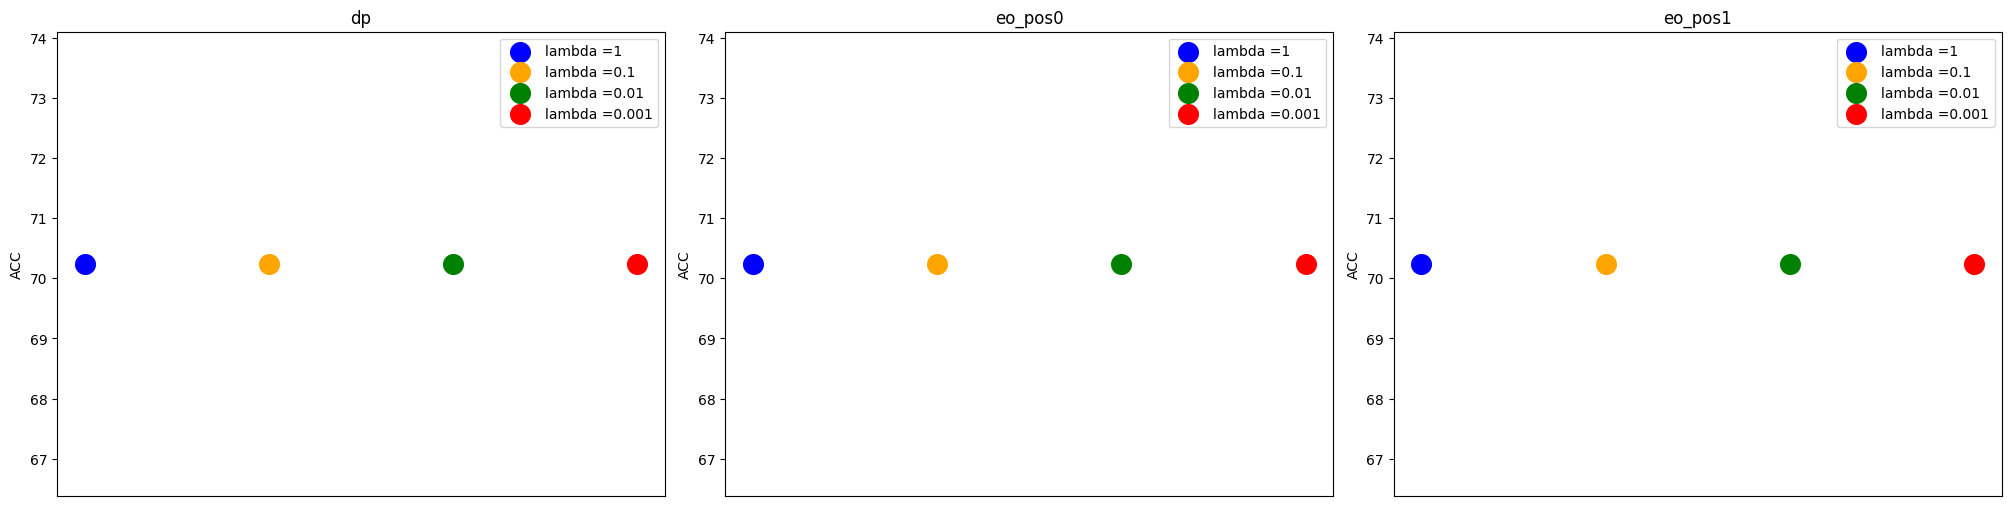

In [71]:

plotScores(scores)

In [73]:
data = BailData(sensitive_attribute = 'WHITE',
                  target_attribute = 'RECID',
                  include_sensitive = True,
                  num_samples = 0,
                  pre_scale_features = False)

In [ ]:
db = 'Bail'
scores = runClassifier(db, data)

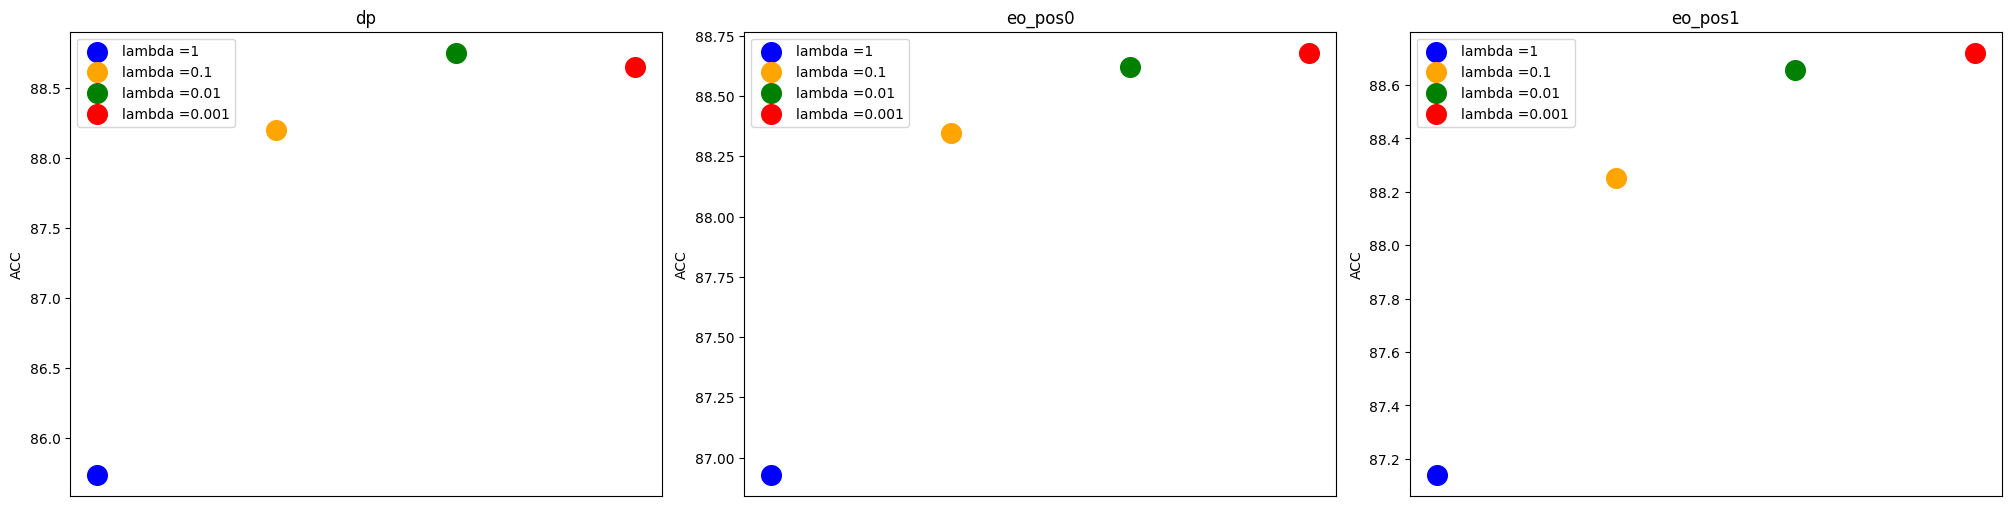

In [75]:
plotScores(scores)

In [78]:
data = CreditData(sensitive_attribute = 'Age',
                  target_attribute = 'NoDefaultNextMonth',
                  include_sensitive = True,
                  num_samples = 0,
                  pre_scale_features = False)

In [ ]:
db = 'Credit'
scores = runClassifier(db, data)

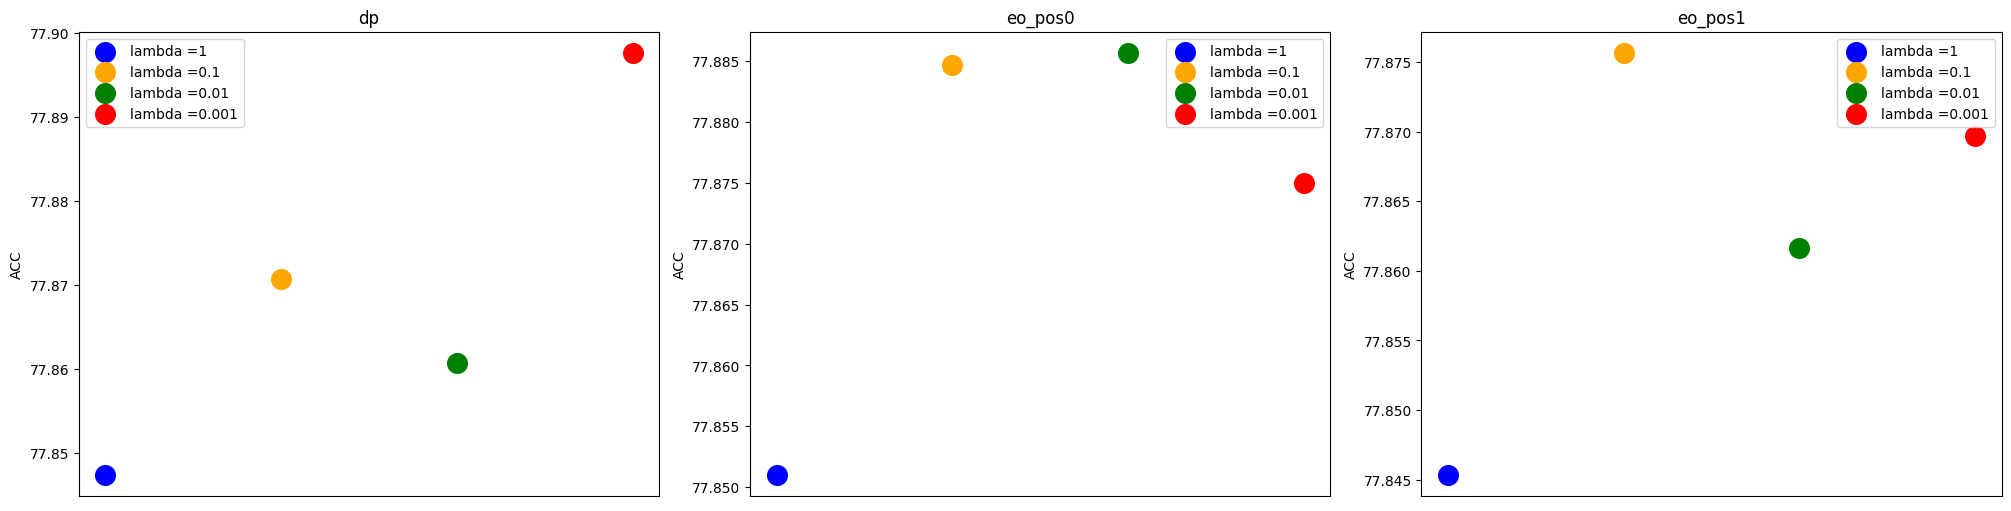

In [80]:
plotScores(scores)